# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction

#### Model

##### Predict if a transaction has capitial gains over 200 USD

In this project, we want to estimate if a transaction will have capital gains exceeding \$200 using the provided dataset. We'll need to create a classification model to do this. There are many different classifying models, such as __Decision Tree__, __Random Forest__, __K Mean Clustering__, etc. A boolean column called `cap_gains_over_200_usd` in the transaction dataset will be True if a transaction contains capital gains over \$200 USD. This would be the output label we would be using, and so this made our prediction to be a classifciation problem. We would take into account several columns in our transaction dataset for the input features. As both our baseline model and final model made advantage of several features.

#### Evaluation

For evaulation of our model, we have chosen to use the following metrics:

- Accuracy score $$\text{accuracy} = \frac{\text{# data points classified correctly}}{\text{# data points}} = \frac{TP + TN}{TP + FP + FN + TN}$$
- Precision score $$\text{precision} = \frac{TP}{\text{# predicted positive}} = \frac{TP}{TP + FP}$$
- Recall score $$\text{recall} = \frac{TP}{\text{# actually positive}} = \frac{TP}{TP + FN}$$

### Baseline Model

#### Description

For the baseline model, we believe that the features of `disclosure_year`, `transaction_date`, `owner`, `type`, `amount` and `party` are related to the output of `cap_gain_over_200`.

Total of 7 features are used in the baseline model, which are the following:

- `disclosure_year`: Categorical ordinal
- `transaction_date`: Categorical ordinal
- `owner`: Categorical nominal
- `type`: Categorical nominal
- `amount`: Quantitative
- `party`: Categorical nominal

The following stages are used in the pipeline to pre-process the input features:

1. One-hot encode `disclosure_year`, `owner` and `party` columns with `OneHotEncoder`.
1. Extract the month of `transaction_date` and then using `Binarizer` to transform it into a boolean Series where $ \text{month} \le 6$  is `False`, otherwise is `True`.
1. Transform the `amount` column into a quantittative feature by calculating the average of thresholds using `FunctionTransformer`.
1. Use the `StdScalerByGroup` to calculate the standardized amount of every transaction by their coresponding party.

#### Performance

Then we process to performing `GridSearchCV` to find out the best parameters for `RandomForestClassifer`. Using the best parameters we have got, our model has the following performance metrics:

- __Percision__: 20%
- __Recall__: 0.346%
- __Accuracy__: 93.79%

##### Confusion matrix

|               | Actually True | Actually False |
| ------------- | ------------- | -------------- |
| Predict True  | 4408          | 4              |
| Predict False | 288           | 1              |

### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

In [128]:
# TODO

In [129]:
transactions = pd.read_csv('data/combined_transactions.csv')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15667 entries, 0 to 15666
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   disclosure_year         15667 non-null  int64 
 1   disclosure_date         15667 non-null  object
 2   transaction_date        15667 non-null  object
 3   owner                   8342 non-null   object
 4   ticker                  14372 non-null  object
 5   asset_description       15663 non-null  object
 6   type                    15667 non-null  object
 7   amount                  15667 non-null  object
 8   representative          15667 non-null  object
 9   district                15667 non-null  object
 10  ptr_link                15667 non-null  object
 11  cap_gains_over_200_usd  15667 non-null  bool  
 12  first_name              15667 non-null  object
 13  last_name               15667 non-null  object
 14  party                   15667 non-null  object
dtypes:

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Binarizer, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

%pip install imblearn
from imblearn.over_sampling import SMOTE


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [131]:
transactions['type'].value_counts(normalize=True)

purchase        0.525819
sale_full       0.314993
sale_partial    0.150316
exchange        0.008808
sale            0.000064
Name: type, dtype: float64

#### pre-processing functions

In [137]:
def month_preproc(df):
    df['transaction_month'] = df['transaction_date'].str.split('-', expand=True).iloc[:, 1].astype(int)
    return Binarizer(threshold=6).fit_transform(df[['transaction_month']])

def amount_preproc(df):
    df['amount_quant'] = (df['amount']
                          .str.replace(r'[+\-$,]', '', regex=True)
                          .str.replace(r'\s+', ' ', regex=True)
                          .str.strip()
                          .str.split()
                          .apply(lambda x: sum(map(int, x)) // len(x)))
    return df[['amount_quant']]


class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def preprocess_(self, df):
        for col in df.columns[1:]:
            df[col] = (df[col]
                       .str.replace(r'[+\-$,]', '', regex=True)
                       .str.replace(r'\s+', ' ', regex=True)
                       .str.strip()
                       .str.split()
                       .apply(lambda x: sum(map(int, x)) // len(x)))
        return df

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X might not be a pandas DataFrame (e.g. a np.array)
        df = self.preprocess_(pd.DataFrame(X))

        # Compute and store the means/standard-deviations for each column (e.g. 'c1' and 'c2'),
        # for each group (e.g. 'A', 'B', 'C').
        # (Our solution uses a dictionary)
        df_agg = df.groupby(df.columns[0]).agg(['mean', 'std'])
        self.grps_ = {(g, c): df_agg.loc[g, c]
                      for g in df_agg.index for c in df_agg.columns}

        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError(
                "You must fit the transformer before tranforming the data!")

        # Hint: Define a helper function here!
        def helper2(df):
            grp_col = df.columns[0]
            grps = df[grp_col].unique()
            df_grps = df.groupby(grp_col)

            df_out = []
            for grp in grps:
                df_grp = df_grps.get_group(grp).iloc[:, 1:]
                for col in df_grp.columns:
                    df_grp[col] = (
                        df_grp[col] - self.grps_[(grp, (col, 'mean'))]) / self.grps_[(grp, (col, 'std'))]
                df_out.append(df_grp)
            return pd.concat(df_out).fillna(0)

        df = pd.DataFrame(X)

        return helper2(df)

#### Grid search

In [150]:
preproc = ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(), ['disclosure_year', 'owner', 'party']),
    ('month', FunctionTransformer(month_preproc, validate=False), ['transaction_date']),
    ('amount', FunctionTransformer(amount_preproc), ['amount']),
    ('std-grp', StdScalerByGroup(), ['party', 'amount'])
])

feature_df = transactions.drop(columns=['cap_gains_over_200_usd'])
label_df = transactions['cap_gains_over_200_usd']


# print(f'new feature count: \n{len(transformed_feature_df)}\n')
# print(f'old feature count: \n{len(feature_df)}\n')

# print(f'new label count: \n{transformed_label_df.value_counts()}\n')
# print(f'old label count: \n{label_df.value_counts()}')

feature_df.shape, label_df.shape

((15667, 14), (15667,))

In [153]:
params = {
    'n_estimators': [2, 5, 10, 25, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 25, 50, 100],
    'min_samples_split': [2, 5, 10, 25, 50, 100]
}

X_train, X_test, y_train, y_test = train_test_split(
    feature_df, label_df, test_size=0.3)
X_train_search = preproc.fit_transform(X_train)

searcher = GridSearchCV(RandomForestClassifier(), params, cv=3)
searcher.fit(X_train_search, y_train)
searcher.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'min_samples_split': 100,
 'n_estimators': 2}

In [161]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, precision_score, recall_score,
    precision_recall_curve
)

pl = Pipeline([
    ('preproc', preproc),
    ('clf', RandomForestClassifier(criterion='gini', max_depth=25,
                                   min_samples_split=100, n_estimators=2))
])

pl.fit(X_train, y_train)

y_pred_train = pl.predict(X_train)
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

y_pred_test = pl.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(recall_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.9388108699616998
[[10283     7]
 [  664    12]]
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     10290
        True       0.63      0.02      0.03       676

    accuracy                           0.94     10966
   macro avg       0.79      0.51      0.50     10966
weighted avg       0.92      0.94      0.91     10966

0.9378855562646246
0.0034602076124567475
[[4408    4]
 [ 288    1]]
              precision    recall  f1-score   support

       False       0.94      1.00      0.97      4412
        True       0.20      0.00      0.01       289

    accuracy                           0.94      4701
   macro avg       0.57      0.50      0.49      4701
weighted avg       0.89      0.94      0.91      4701



In [158]:
precision_recall_curve

### Final Model

In [ ]:
# TODO

#### pre-processing functions

In [ ]:
def month_preproc(df):
    df['transaction_month'] = df['transaction_date'].str.split('-', expand=True).iloc[:, 1].astype(int)
    return Binarizer(threshold=6).fit_transform(df[['transaction_month']])

def amount_preproc(df):
    df['amount_quant'] = (df['amount']
                          .str.replace(r'[+\-$,]', '', regex=True)
                          .str.replace(r'\s+', ' ', regex=True)
                          .str.strip()
                          .str.split()
                          .apply(lambda x: sum(map(int, x)) // len(x)))
    return df[['amount_quant']]


class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def preprocess_(self, df):
        for col in df.columns[1:]:
            df[col] = (df[col]
                       .str.replace(r'[+\-$,]', '', regex=True)
                       .str.replace(r'\s+', ' ', regex=True)
                       .str.strip()
                       .str.split()
                       .apply(lambda x: sum(map(int, x)) // len(x)))
        return df

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X might not be a pandas DataFrame (e.g. a np.array)
        df = self.preprocess_(pd.DataFrame(X))

        # Compute and store the means/standard-deviations for each column (e.g. 'c1' and 'c2'),
        # for each group (e.g. 'A', 'B', 'C').
        # (Our solution uses a dictionary)
        df_agg = df.groupby(df.columns[0]).agg(['mean', 'std'])
        self.grps_ = {(g, c): df_agg.loc[g, c]
                      for g in df_agg.index for c in df_agg.columns}

        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError(
                "You must fit the transformer before tranforming the data!")

        # Hint: Define a helper function here!
        def helper2(df):
            grp_col = df.columns[0]
            grps = df[grp_col].unique()
            df_grps = df.groupby(grp_col)

            df_out = []
            for grp in grps:
                df_grp = df_grps.get_group(grp).iloc[:, 1:]
                for col in df_grp.columns:
                    df_grp[col] = (
                        df_grp[col] - self.grps_[(grp, (col, 'mean'))]) / self.grps_[(grp, (col, 'std'))]
                df_out.append(df_grp)
            return pd.concat(df_out).fillna(0)

        df = pd.DataFrame(X)

        return helper2(df)

#### balance dataset

In [ ]:
from imblearn.pipeline import Pipeline as iPipeline

preproc = ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(), ['disclosure_year', 'owner', 'party']),
    ('month', FunctionTransformer(month_preproc, validate=False), ['transaction_date']),
    ('amount', FunctionTransformer(amount_preproc), ['amount']),
    ('std-grp', StdScalerByGroup(), ['party', 'amount'])
])

ipl = iPipeline([
    ('preproc', preproc),
    ('smt', SMOTE()),
#     ('clf', RandomForestClassifier(criterion='gini', max_depth=25,
#                                    min_samples_split=2, n_estimators=25))
])

feature_df = transactions.drop(columns=['cap_gains_over_200_usd'])
label_df = transactions['cap_gains_over_200_usd']

transformed_feature_df, transformed_label_df = ipl.fit_resample(feature_df, label_df)

# print(f'new feature count: \n{len(transformed_feature_df)}\n')
# print(f'old feature count: \n{len(feature_df)}\n')

# print(f'new label count: \n{transformed_label_df.value_counts()}\n')
# print(f'old label count: \n{label_df.value_counts()}')

In [ ]:
params = {
    'n_estimators': [2, 5, 10, 25, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 25, 50, 100],
    'min_samples_split': [2, 5, 10, 25, 50, 100]
}

# X_train, X_test, y_train, y_test = train_test_split(
#     transformed_feature_df, transformed_label_df, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(
    transformed_feature_df, transformed_label_df, test_size=0.3)

# searcher = GridSearchCV(RandomForestClassifier(), params, cv=3)
# searcher.fit(X_train, y_train)
# searcher.best_params_

In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, precision_score,
    precision_recall_curve
)

pl = Pipeline([
    ('clf', RandomForestClassifier(criterion='gini', max_depth=25,
                                   min_samples_split=2, n_estimators=25))
])

pl.fit(X_train, y_train)

y_pred_train = pl.predict(X_train)
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

y_pred_test = pl.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

### Fairness Evaluation

In [ ]:
# TODO

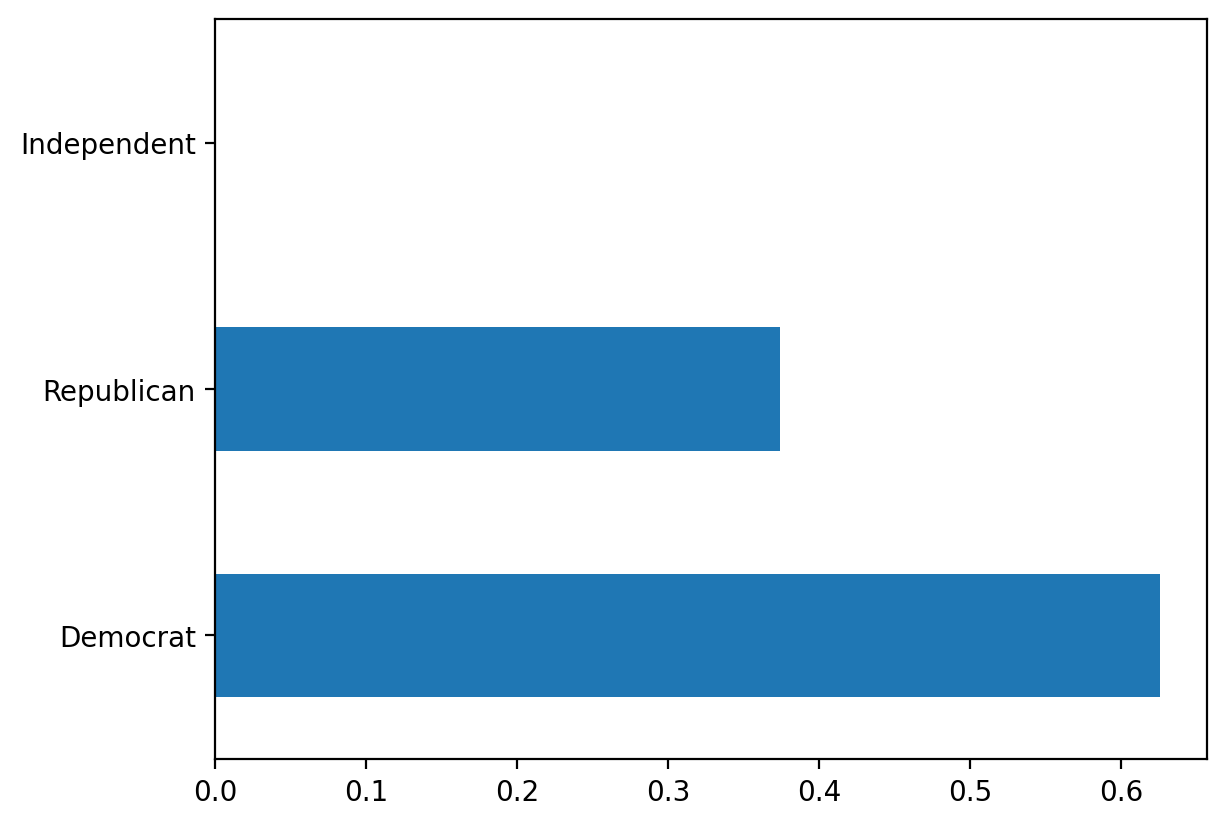

In [170]:
transactions['party'].value_counts(normalize=True).plot(kind='barh');

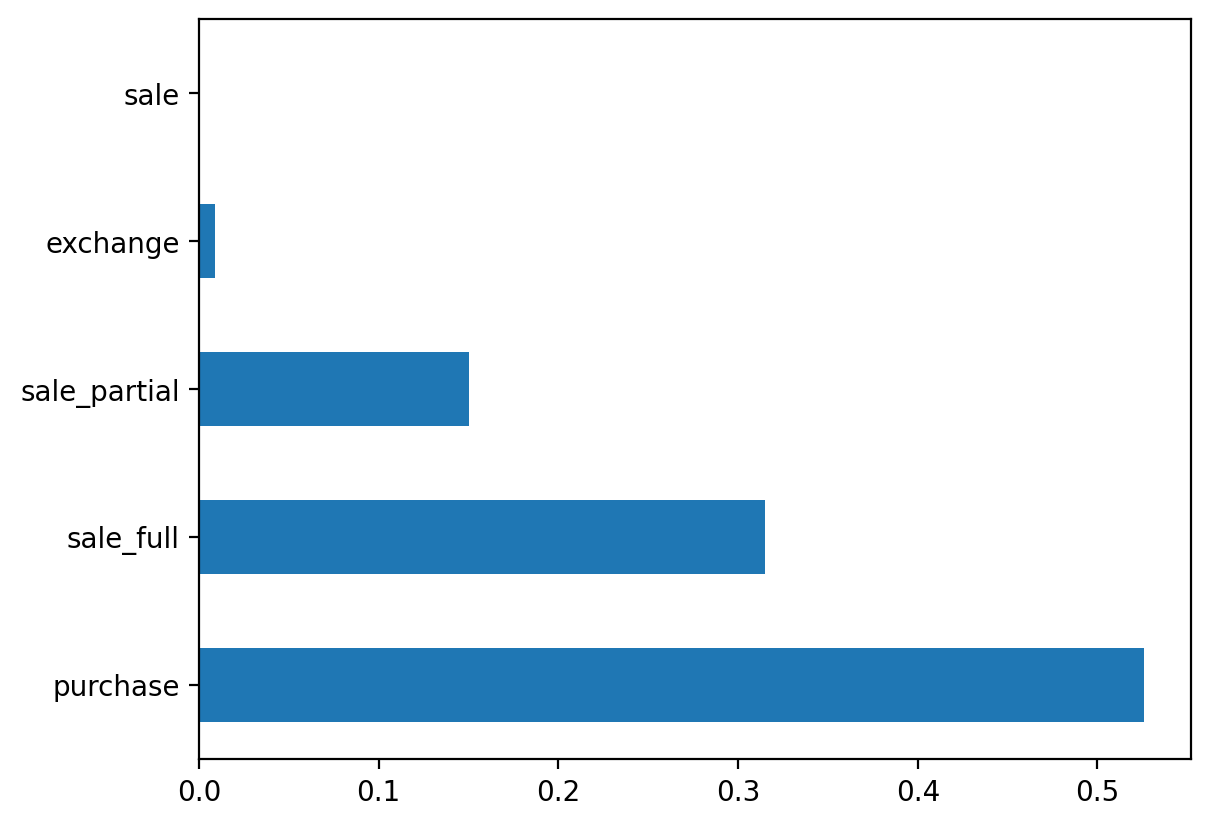

In [173]:
transactions['type'].value_counts(normalize=True).plot(kind='barh');

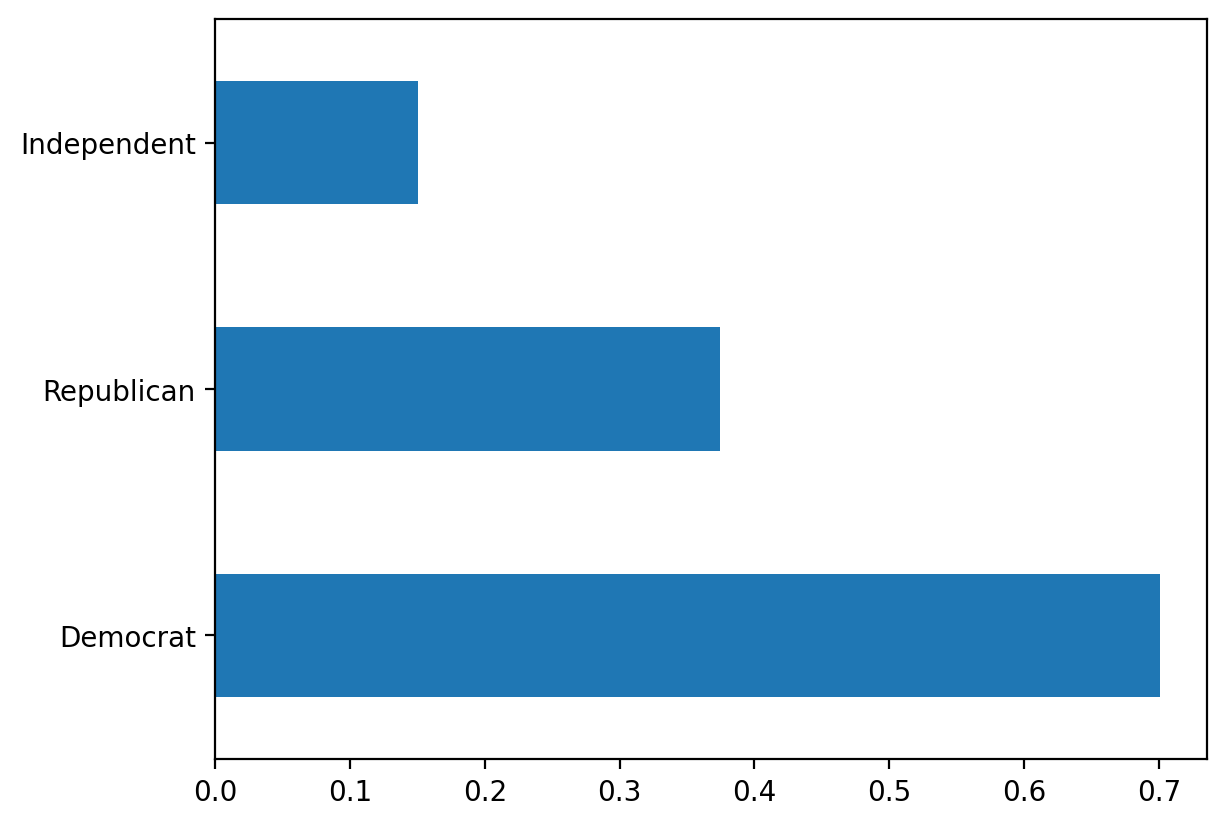

In [175]:
transactions['amount'].value_counts(normalize=True).plot(kind='barh');
transactions['type'].value_counts(normalize=True).plot(kind='barh');
transactions['party'].value_counts(normalize=True).plot(kind='barh');